<a href="https://colab.research.google.com/github/imZiho/Deep-Learning_Seminar/blob/main/CHA07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no suc

In [2]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [3]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [4]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [5]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

# **다중분류**

기존 3개의 붓꽃데이터셋을 2종류로 줄여 이진분류에 사용했지만
여기서는 세 종류 모두 학습 데이터로 사용한다.

(이진분류와의 차이점)

0. 출력부분에서의 큰 차이점 (선형회귀모델이나 이진분류모델 모두 출력은 1차원에 그쳤지만 다중분류모델에서는 분류하려는 그룹의 개수를 N개라고 했을때, N차원 출력이 된다)

1. 이진분류의 예측에서 사용한 시그모이드 함수가 소프트맥스함수로 불리는 별개의 함수로 바뀐다

2. 손실함수는 교차엔트로피 함수 그대로 사용하지만 형식에는 차이가 있다

3. 이진분류에서는 가중치 벡터였으나 다중분류에서는 가중치 행렬로 대체된다

**소프트맥스 함수란?**

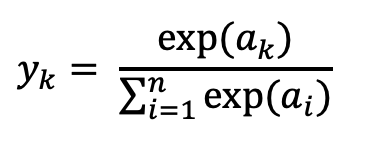

위와 같은 식으로 표현되는 함수이며 시그모이드 함수와 마찬가지로 출력으로 확률값을 내주는 성질을 갖는다.


소프트맥스함수는 입력 중에서 가장 큰 값의 확률이 가장 크도로 출력한다

즉 파이토치의 레이어 함수인 선형함수와 소프트맥스 함수를 이어 붙이면 여러 확률 값을 반환하는 예측모델을 구성할 수 있다.

**교차 엔트로피 함수**

교차 엔트로피 함수는 소프트맥스 함수의 중간 텐서 안의 모든 요소들에 대해 로그를 취해 정답 요소만을 골라낸다.

손실함수로 넘겨줄 정답인 두번쨰 인수는 반드시 정수값으로 이루어져야한다.


# **07.다중분류 실습**

데이터 불러오기

In [9]:
# 학습용 데이터 준비

# 라이브러리 임포트
from sklearn.datasets import load_iris

# 데이터 불러오기
iris = load_iris()

# 입력 데이터와 정답 데이터
x_org, y_org = iris.data, iris.target

# 결과 확인
print('원본 데이터', x_org.shape, y_org.shape)

원본 데이터 (150, 4) (150,)


**데이터 추출**

In [10]:
# data는 꽃잎의 길이와 폭, 꽃받침의 길이와 폭을 수치 값으로 가지고 있는 NumPy 배열이다.
# 입력 데이터로 sepal(꽃받침) length(0)와 petal(꽃잎) length(2)를 추출
x_select = x_org[:,[0,2]]     #행렬의 특정 열들을 선택하는 표기법

# 결과 확인
print('원본 데이터', x_select.shape, y_org.shape)

원본 데이터 (150, 2) (150,)


In [11]:
# 훈련 데이터와 검증 데이터로 분할(셔플도 동시에 실시함)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


In [12]:
# 데이터를 정답별로 분할

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

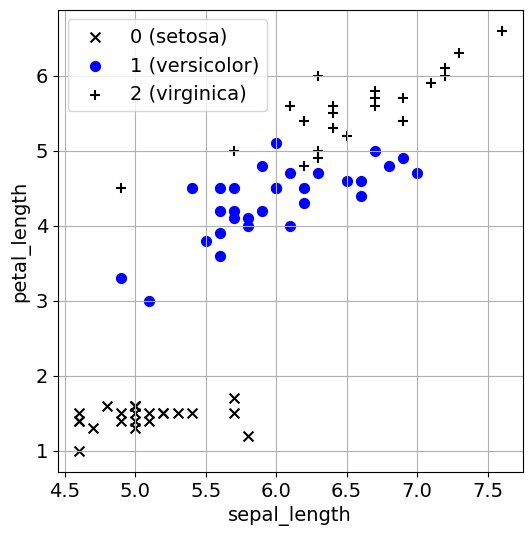

In [13]:
# 산포도 출력

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolor)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()